# Entraînement et Évaluation du Modèle de Prédiction de la Qualité du Sommeil

Ce notebook présente l'entraînement et l'évaluation des différents modèles, avec une attention particulière au SVR qui s'est révélé être le plus performant.

## 1. Importation des bibliothèques

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import json
import os
import time

# Configuration de l'affichage
plt.style.use('seaborn-v0_8')

## 2. Chargement des données prétraitées

In [11]:
# Charger les données prétraitées
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
data_dir = os.path.join(project_root, 'data', 'processed')
X_train = np.load(os.path.join(data_dir, 'X_train.npy'))
X_test = np.load(os.path.join(data_dir, 'X_test.npy'))
y_train = np.load(os.path.join(data_dir, 'y_train.npy'))
y_test = np.load(os.path.join(data_dir, 'y_test.npy'))

# Charger les métadonnées
with open(os.path.join(data_dir, 'preprocessing_metadata.json'), 'r') as f:
    preprocessing_metadata = json.load(f)

print("Features sélectionnées:", preprocessing_metadata['selected_features'])
print("\nDimensions des données:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

Features sélectionnées: ['Age', 'Sleep Duration', 'Stress Level', 'Heart Rate']

Dimensions des données:
X_train: (299, 4)
X_test: (75, 4)


## 3. Configuration des modèles

In [12]:
def get_model_params():
    """Définit les paramètres de chaque modèle avec régularisation stricte"""
    return {
        'Linear Regression': (
            LinearRegression(),
            {}
        ),
        'Ridge': (
            Ridge(),
            {
                'alpha': [1.0, 10.0, 100.0]
            }
        ),
        'SVR': (
            SVR(),
            {
                'C': [0.01, 0.1, 1.0],
                'kernel': ['rbf', 'linear'],
                'gamma': ['scale', 'auto'],
                'epsilon': [0.2, 0.3]
            }
        ),
        'Decision Tree': (
            DecisionTreeRegressor(random_state=42),
            {
                'max_depth': [2, 3],
                'min_samples_split': [20, 30],
                'min_samples_leaf': [10, 15],
                'max_features': ['sqrt']
            }
        ),
        'Random Forest': (
            RandomForestRegressor(random_state=42),
            {
                'n_estimators': [50],
                'max_depth': [3],
                'min_samples_split': [20],
                'min_samples_leaf': [10],
                'max_features': ['sqrt'],
                'bootstrap': [True],
                'max_samples': [0.7]
            }
        ),
        'Gradient Boosting': (
            GradientBoostingRegressor(random_state=42),
            {
                'n_estimators': [50],
                'max_depth': [2],
                'min_samples_split': [20],
                'min_samples_leaf': [10],
                'learning_rate': [0.01],
                'subsample': [0.7],
                'max_features': ['sqrt']
            }
        )
    }

## 4. Validation croisée imbriquée

In [13]:
def nested_cross_validation(model, param_grid, X, y):
    """Effectue une validation croisée imbriquée"""
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)
    
    outer_scores = []
    
    for train_idx, val_idx in outer_cv.split(X):
        X_train_cv, X_val = X[train_idx], X[val_idx]
        y_train_cv, y_val = y[train_idx], y[val_idx]
        
        # GridSearch interne
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            cv=inner_cv,
            scoring='r2',
            n_jobs=-1
        )
        
        grid_search.fit(X_train_cv, y_train_cv)
        
        # Évaluation sur le fold de validation
        y_pred = grid_search.predict(X_val)
        outer_scores.append({
            'r2': r2_score(y_val, y_pred),
            'rmse': np.sqrt(mean_squared_error(y_val, y_pred)),
            'best_params': grid_search.best_params_
        })
    
    return outer_scores

## 5. Évaluation des modèles

In [14]:
# Obtenir les modèles et leurs paramètres
models = get_model_params()

# Évaluer chaque modèle
results = []
for name, (model, params) in models.items():
    print(f"\nÉvaluation de {name}...")
    start_time = time.time()
    
    # Nested cross-validation
    cv_scores = nested_cross_validation(model, params, X_train, y_train)
    
    training_time = time.time() - start_time
    
    # Calculer les moyennes et écarts-types
    metrics = {
        'model_name': name,
        'r2_mean': np.mean([s['r2'] for s in cv_scores]),
        'r2_std': np.std([s['r2'] for s in cv_scores]),
        'rmse_mean': np.mean([s['rmse'] for s in cv_scores]),
        'rmse_std': np.std([s['rmse'] for s in cv_scores]),
        'training_time': training_time,
        'best_params': cv_scores[0]['best_params']
    }
    
    results.append(metrics)
    print(f"R² moyen: {metrics['r2_mean']:.4f} (±{metrics['r2_std']:.4f})")

# Convertir en DataFrame
results_df = pd.DataFrame(results)


Évaluation de Linear Regression...
R² moyen: 0.8913 (±0.0110)

Évaluation de Ridge...
R² moyen: 0.8906 (±0.0105)

Évaluation de SVR...
R² moyen: 0.9472 (±0.0190)

Évaluation de Decision Tree...
R² moyen: 0.9250 (±0.0331)

Évaluation de Random Forest...
R² moyen: 0.9356 (±0.0277)

Évaluation de Gradient Boosting...
R² moyen: 0.5546 (±0.0188)


## 6. Visualisation des résultats

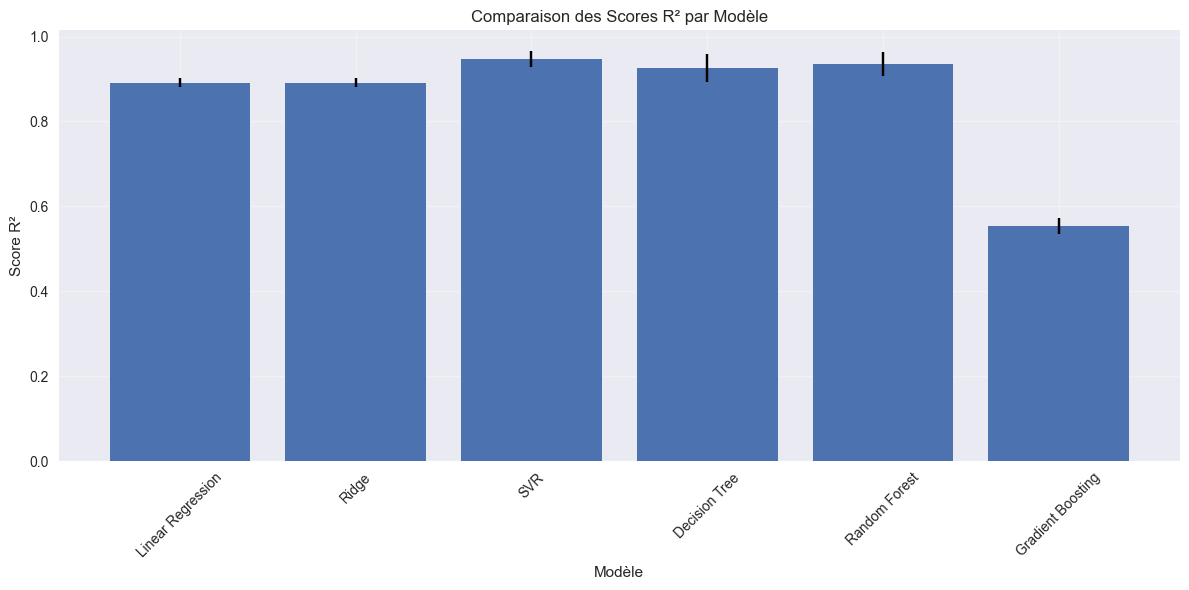

,Modèle,R²,RMSE,Temps (s)
0,Linear Regression,0.8913 ± 0.0110,0.3885 ± 0.0314,2.9583
1,Ridge,0.8906 ± 0.0105,0.3898 ± 0.0312,0.6315
2,SVR,0.9472 ± 0.0190,0.2674 ± 0.0568,0.1975
3,Decision Tree,0.9250 ± 0.0331,0.3169 ± 0.0732,0.1306
4,Random Forest,0.9356 ± 0.0277,0.2938 ± 0.0797,0.3801
5,Gradient Boosting,0.5546 ± 0.0188,0.7872 ± 0.0538,0.1790


In [15]:
# Graphique des scores R²
plt.figure(figsize=(12, 6))
plt.bar(results_df['model_name'], results_df['r2_mean'], 
        yerr=results_df['r2_std'], capsize=5)
plt.title('Comparaison des Scores R² par Modèle')
plt.xlabel('Modèle')
plt.ylabel('Score R²')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Tableau des résultats
display_df = pd.DataFrame([
    {
        'Modèle': r['model_name'],
        'R²': f"{r['r2_mean']:.4f} ± {r['r2_std']:.4f}",
        'RMSE': f"{r['rmse_mean']:.4f} ± {r['rmse_std']:.4f}",
        'Temps (s)': f"{r['training_time']:.4f}"
    }
    for r in results
])
display(display_df)

## 7. Entraînement du meilleur modèle (SVR)

In [16]:
# Identifier le meilleur modèle
best_model_name = results_df.loc[results_df['r2_mean'].idxmax(), 'model_name']
best_model_results = next(r for r in results if r['model_name'] == best_model_name)

# Créer et entraîner le meilleur modèle
best_model, _ = models[best_model_name]
best_model.set_params(**best_model_results['best_params'])
best_model.fit(X_train, y_train)

# Évaluer sur le jeu de test
y_pred = best_model.predict(X_test)
test_r2 = r2_score(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nRésultats sur le jeu de test final pour {best_model_name}:")
print(f"R² = {test_r2:.4f}")
print(f"RMSE = {test_rmse:.4f}")


Résultats sur le jeu de test final pour SVR:
R² = 0.9680
RMSE = 0.2198


## 8. Visualisation des prédictions

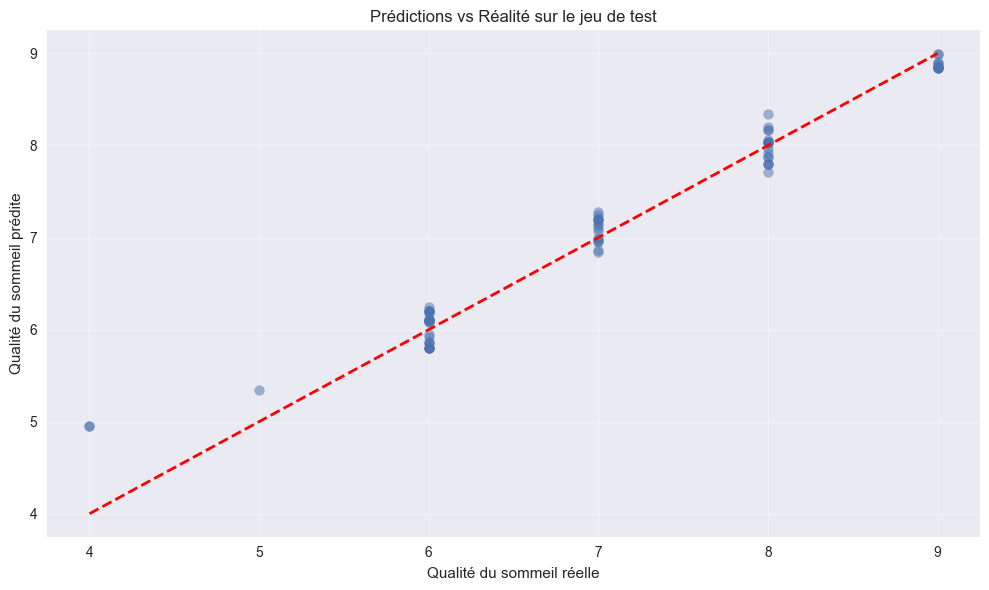

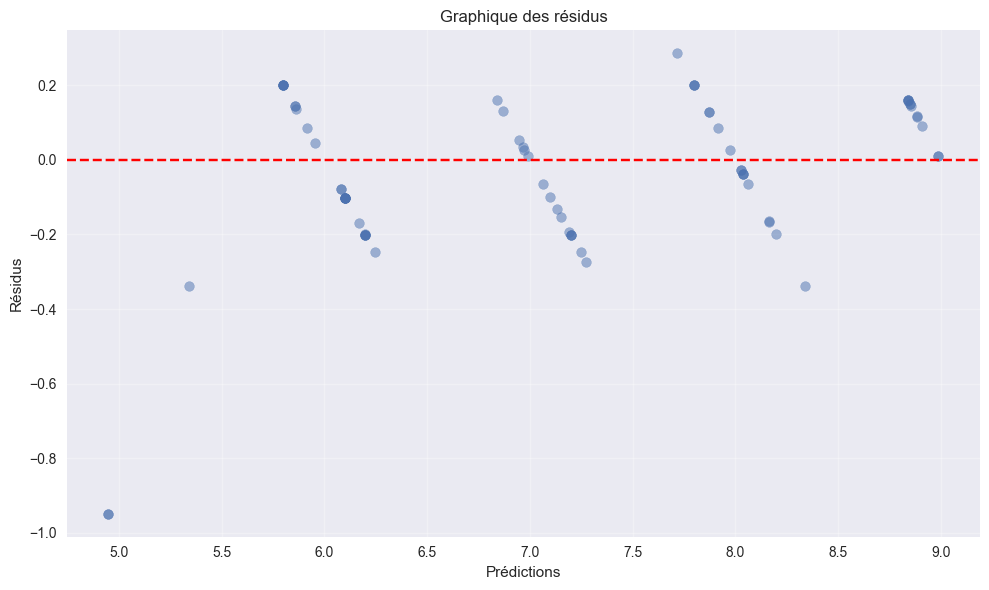

In [17]:
# Graphique des prédictions vs réalité
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Qualité du sommeil réelle')
plt.ylabel('Qualité du sommeil prédite')
plt.title('Prédictions vs Réalité sur le jeu de test')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Graphique des résidus
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Graphique des résidus')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Sauvegarde du modèle final

In [18]:
# Sauvegarder les résultats de la comparaison
output_dir = os.path.join(project_root, 'models', 'comparison_results')
os.makedirs(output_dir, exist_ok=True)

results_df = pd.DataFrame([
    {
        'model_name': r['model_name'],
        'r2_score': f"{r['r2_mean']:.4f} ± {r['r2_std']:.4f}",
        'rmse': f"{r['rmse_mean']:.4f} ± {r['rmse_std']:.4f}",
        'training_time': f"{r['training_time']:.4f}s",
        'best_params': str(r['best_params'])
    }
    for r in results
])

results_df.to_csv(os.path.join(output_dir, 'model_comparison.csv'), index=False)

# Sauvegarder les métadonnées avec les résultats du test final
metadata = {
    'selected_features': preprocessing_metadata['selected_features'],
    'best_model': best_model_name,
    'comparison_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'dataset_size': len(X_train) + len(X_test),
    'train_size': len(X_train),
    'test_size': len(X_test),
    'cross_validation': {
        'outer_folds': 5,
        'inner_folds': 3
    },
    'final_test_results': {
        'r2_score': float(test_r2),
        'rmse': float(test_rmse)
    }
}

with open(os.path.join(output_dir, 'model_metadata.json'), 'w') as f:
    json.dump(metadata, f, indent=4)

print("\nRésultats et métadonnées sauvegardés avec succès!")


Résultats et métadonnées sauvegardés avec succès!
